In [61]:
import cv2
import os
import glob
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load camera calibration
with open('camera_cal.p', mode='rb') as f:
    camera_cal=pickle.load(f)
mtx=camera_cal['mtx']
dist=camera_cal['dist']

In [62]:
# Use color transforms, gradients, etc., to create a thresholded binary image.
# Colour transform
def color_thresh(img, thresh=(0,255)):
    hls=cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s=hls[:,:,2]

    # Color threshold to isolate yellow and white 
    s_binary=np.zeros_like(s)
    s_binary[[((s>thresh[0]) & (s<thresh[1]))]]=1
    
    #plt.imshow(np.dstack((255*s_binary,np.zeros_like(s), s)))
    #plt.show()
    return (s_binary)




In [63]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    # Apply the following steps to img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    #default is to use sobel x
    if orient=='x':
        gradient=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    if orient=='y':
        gradient=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)        

    # 3) Take the absolute value of the derivative or gradient
    abs_grad=np.absolute(gradient)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scale_factor=np.max(abs_grad)/255.0
    abs_grad=(abs_grad/scale_factor).astype(np.uint8)

    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    mask=[(abs_grad>thresh[0]) & (abs_grad<thresh[1])]

    # 6) Return this mask as your binary_output image
    binary_output=np.zeros_like(abs_grad).astype(np.uint8)
    binary_output[mask]=1    
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
   
    # Apply the following steps to img
    # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    sobel_mag=np.sqrt(sobelx**2+sobely**2)
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    with np.errstate(divide='ignore', invalid='ignore'):
        sobel_mag=np.uint8(255*sobel_mag/np.max(sobel_mag))
    # 6) Create a binary mask where mag thresholds are met
    mask =[(sobel_mag > mag_thresh[0]) & (sobel_mag < mag_thresh[1])]
    # 7) Return this mask as your binary_output image
    binary_output=np.zeros_like(sobel_mag).astype(np.uint8)
    binary_output[mask] = 1
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):    
    # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the direction of the gradient 
    with np.errstate(divide='ignore', invalid='ignore'):
        sobel_phase=np.arctan(sobely/(sobelx))
        # 4) Take the absolute value
        sobel_abs_phase=np.absolute(sobel_phase)
        # 5) Create a binary mask where direction thresholds are met
        mask =[(sobel_abs_phase > thresh[0]) & (sobel_abs_phase < thresh[1])]
        # 6) Return this mask as your binary_output image
        dir_binary=np.zeros_like(sobel_abs_phase).astype(np.uint8)
        dir_binary[mask] = 1
    return dir_binary

def detect_sobel_edges(img):
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ksize=15
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(10, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(100, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.4, 1.5))
    
    edges = np.zeros_like(dir_binary)
    #edges[((gradx == 1) & (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    #edges[((gradx == 1) & (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    edges[((gradx == 1) )] = 1
    return edges


In [64]:
# Region masking
def region_masking(img):
    ysize = img.shape[0]
    xsize = img.shape[1]

    left_bottom = [0.1*xsize, ysize-1]
    left_top = [0.4*xsize, 0.6*ysize]
    right_top = [0.6*xsize, 0.6*ysize]
    right_bottom = [0.9*xsize, ysize-1]

    # Fit lines (y=Ax+B) to identify the  3 sided region of interest
    # np.polyfit() returns the coefficients [A, B] of the fit
    fit_left = np.polyfit((left_bottom[0], left_top[0]), (left_bottom[1], left_top[1]), 1)
    fit_top = np.polyfit((left_top[0], right_top[0]), (left_top[1], right_top[1]), 1)
    fit_right = np.polyfit((right_top[0], right_bottom[0]), (right_top[1], right_bottom[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_top[0] + fit_top[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1]))

    binary_lane=np.zeros_like(img)
    binary_lane[region_thresholds & (img==1)]=1
        
    return binary_lane

In [137]:
def calc_slope(line):
    [[x1,y1,x2,y2]]=line
    slope=(y2-y1)/(x2-x1)
    return slope

def find_lane_trapezoid(img, lines, color=[255, 0, 0], thickness=7):   
    shape_ymax, shape_xmax = img.shape
   
    """   Calculate slopes and group the lines into left and right     """
    right_lines=[]
    left_lines=[]
    slopes=[]
    slope_thres=0.5
    for line in lines:
        slope=calc_slope(line)
        slopes.append(slope)
        if(slope>slope_thres):
            right_lines.append(line)
        elif(slope<-slope_thres):
            left_lines.append(line)

    """        Averaging        """
    left_line =np.mean(left_lines,axis=0)
    left_line =left_line.astype(int)
    right_line=np.mean(right_lines,axis=0)
    right_line=right_line.astype(int)

    """        Extrapolate        """
    y_thres=int(0.8*shape_ymax)
    m=calc_slope(left_line)
    [[x1,y1,x2,y2]]=left_line
    xmin_left=int(x1+(shape_ymax-y1)/m)
    xmax_left=int(x2-(y2-y_thres)/m)
    #cv2.line(img, (xmin_left, shape_ymax), (xmax_left, y_thres), color, thickness)

    m=calc_slope(right_line)
    [[x1,y1,x2,y2]]=right_line
    xmax_right=int(x2+(shape_ymax-y2)/m)
    xmin_right=int(x1-(y1-y_thres)/m)        
    #cv2.line(img, (xmin_right, y_thres), (xmax_right, shape_ymax), color, thickness)    
    #cv2.line(img, (xmax_left, y_thres), (xmin_right, y_thres), color, thickness)
    
    trapezoid_corners=[[xmin_left, shape_ymax],[xmax_left, y_thres],[xmin_right, y_thres],[xmax_right, shape_ymax]]    
    #plt.imshow(img, cmap='gray')
    #plt.show()
    return trapezoid_corners
    
def hough_lines(hough_img, rho=2, theta= np.pi/180, threshold=40, min_line_len=10, max_line_gap=170):
    """   Take only the bottom part of the image which is more likely to be straight lines     """
    """   This is to avoid the upper curve line to skew the straight line finding  """
    shape_ymax, shape_xmax = hough_img.shape
    img=hough_img.copy()
    img[:int(0.7*shape_ymax),:]=0    
    #plt.imshow(img,cmap='gray')
    #plt.show()
    lines = cv2.HoughLinesP(img, rho, theta, threshold,np.array([]),min_line_len, max_line_gap)
    return lines

# Apply a perspective transform to rectify binary image ("birds-eye view").
def find_trapezoid_corners(img):
    # Hough transform to find line
    #line_image = np.copy(binary_lane,np.uint8)
    # Run Hough on edge detected image
    lines = hough_lines(img.copy())
    # Find straight 4 trapezoid corners on the straight lanes
    scr_pts=find_lane_trapezoid(img,lines)
    
    return scr_pts

def bird_eye(img, source_points):
    shape_ymax, shape_xmax = img.shape
    #src_pts=np.float32(find_trapezoid_corners(img))
    src_pts=np.float32(source_points)
    
    dst_pts=np.array([[0.3*shape_xmax,shape_ymax],[0.3*shape_xmax,0.9*shape_ymax],
                      [0.7*shape_xmax,0.9*shape_ymax],[0.7*shape_xmax,shape_ymax]],np.float32)
    M = cv2.getPerspectiveTransform(src_pts,dst_pts) 
    
    warped=cv2.warpPerspective(img,M,img.shape[::-1],flags=cv2.INTER_LINEAR)
    return warped, M

# Find lane boundary
# Function to find lane boundary and return an binary image
def find_lane(img, x_init_pos, wdw_dx=75, wdw_dy=75):
    shape_ymax, shape_xmax=img.shape
    windowed=np.zeros_like(img)
    # start the search from peak
    x_mean=x_init_pos
    for y in range(shape_ymax, 0, -wdw_dy):
        wdw=img[y-wdw_dy:y,x_mean-wdw_dx:x_mean+wdw_dx].copy()
        windowed[y-wdw_dy:y,x_mean-wdw_dx:x_mean+wdw_dx]=wdw.copy()
        # Calculate new mean of x
        histogram = np.sum(wdw, axis=0)
        x_mean=x_mean+np.argmax(histogram)-wdw_dx
    return windowed

# Detect lane pixels and fit to find lane boundary
def find_lane_boundary(img, dbg=False):
    histogram = np.sum(img, axis=0)
    if dbg==True:
        plt.plot(histogram)
        plt.show()
    half_len=int(len(histogram)/2)
    #left_peak=np.argmax(histogram[:half_len])
    #right_peak=half_len+np.argmax(histogram[half_len:])
    left_peak=int(0.3*img.shape[1])
    right_peak=int(0.7*img.shape[1])
    
    left_lane=find_lane(img, left_peak)
    right_lane=find_lane(img, right_peak)
    return left_lane, right_lane

In [138]:
# Determine curvature of the lane and vehicle position with respect to center
def calc_curvature(left_lane, right_lane, xm_per_pix, ym_per_pix, dbg=False):
    shape_ymax, shape_xmax = left_lane.shape
    y = np.linspace(0, shape_ymax, num=shape_ymax)

    # Get the x,y indexes with non-zero elements i.e. white lines
    y_left,x_left=np.nonzero(left_lane)
    y_right,x_right=np.nonzero(right_lane)

    # Polynomial fitting
    left_fit=np.polyfit(y_left,x_left,2)
    left_fitted_curve = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]

    right_fit=np.polyfit(y_right,x_right,2)
    right_fitted_curve = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]

    if dbg==True:
        # Plt on graph
        plt.plot(x_left, y_left, '.', color='white')
        plt.plot(left_fitted_curve, y, color='red', linewidth=3)

        plt.plot(x_right, y_right, '.', color='white')
        plt.plot(right_fitted_curve, y, color='red', linewidth=3)

        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        ax = plt.gca()
        ax.set_axis_bgcolor('black')
        plt.gca().invert_yaxis()
        plt.show()

    # Curvature
    y_eval = shape_ymax
    left_fit_cr=np.polyfit(y_left*ym_per_pix,x_left*xm_per_pix,2)
    right_fit_cr=np.polyfit(y_right*ym_per_pix,x_right*xm_per_pix,2)

    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    # Radius of curvature in meters
    return left_curverad,  right_curverad, left_fit, right_fit


In [139]:
def fill_poly_unwarp(img, warped, warp_matrix, left_fit, right_fit):
    # Warp the detected lane boundaries back onto the original image
    shape_ymax, shape_xmax, _ =img.shape
    y = np.linspace(0, shape_ymax, num=shape_ymax)
    left_fitted_curve = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right_fitted_curve = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitted_curve, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitted_curve, y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv=np.linalg.inv(warp_matrix)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

In [140]:
def process_image(img, dbg=False):
    #Apply distortion correction to the raw image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if dbg==True:
        plt.imshow(undist)
        plt.show()

    # Threshold gradient
    edges=detect_sobel_edges(undist)
    if dbg==True:
        plt.imshow(edges, cmap='gray')
        plt.show()

    # Threshold color
    color_binary=color_thresh(undist, (100,255))

    if dbg==True:
        plt.imshow(255*np.dstack((color_binary,np.zeros_like(edges),edges)))
        plt.show()

    # Combine gradient and color thresholds
    grad_color_masked=np.zeros_like(color_binary)
    grad_color_masked[(edges==1) | (color_binary==1)]=1    
    if dbg==True:
        plt.imshow(grad_color_masked, cmap='gray')
        plt.show()

    binary_lane=region_masking(grad_color_masked)
    if dbg==True:
        plt.imshow(binary_lane, cmap='gray')
        plt.show()

    # Warp
    #src_pts=find_trapezoid_corners(binary_lane)
    src_pts=np.array([[271, 720], [453, 576], [925, 576], [1178, 720]],np.int)
    warped, warp_matrix=bird_eye(binary_lane, src_pts)
    if dbg==True:
        print("src_pts", src_pts)
        plt.imshow(warped,cmap='gray')
        plt.show()

    # Plot the trapezoid
    line_pic = undist.copy()
    color=[255,0,0]
    thickness=10
    cv2.line(line_pic, (src_pts[0][0], src_pts[0][1]), (src_pts[1][0], src_pts[1][1]),color, thickness)
    cv2.line(line_pic, (src_pts[1][0], src_pts[1][1]), (src_pts[2][0], src_pts[2][1]),color, thickness)
    cv2.line(line_pic, (src_pts[2][0], src_pts[2][1]), (src_pts[3][0], src_pts[3][1]),color, thickness)
    cv2.line(line_pic, (src_pts[3][0], src_pts[3][1]), (src_pts[0][0], src_pts[0][1]),color, thickness)
    if dbg==True:
        plt.imshow(line_pic)
        plt.show()

    # Define conversions in  y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension

    # Calculate meteres per pixel in x dimension
    lane_width_m = 3.7  # assume physical width of lane is 3.7m
    xm_per_pix=lane_width_m/(src_pts[3][0]-src_pts[0][0])

    # Find lanes
    left_lane,right_lane=find_lane_boundary(warped, dbg)
    if dbg==True:    
        plt.imshow(left_lane,cmap='gray')
        plt.show()
        plt.imshow(right_lane,cmap='gray')
        plt.show()

    combine_lanes=cv2.addWeighted(left_lane,1,right_lane,1,0)
    if dbg==True:
        plt.imshow(combine_lanes,cmap='gray')
        plt.show()

    # Calculate the position of car relative to lane center
    car_center=img.shape[1]/2
    lane_center=(src_pts[3][0]+src_pts[0][0])/2
    lane_offset=lane_width_m*(car_center-lane_center)/(src_pts[3][0]-src_pts[0][0])
    if dbg==True:
        print('lane_offset',lane_offset,'m')
        
    # Find curvature 
    left_curverad,  right_curverad, left_fit, right_fit =  calc_curvature(left_lane, right_lane, xm_per_pix, ym_per_pix, dbg)
    curverad=(left_curverad+right_curverad)/2
    
    # fill polygon and unwarp into original image
    result=fill_poly_unwarp(undist, warped, warp_matrix, left_fit, right_fit)
    
    # add texts
    cv2.putText(result, "Radius of Curvature ="+str(int(curverad))+"(m)", (20, 50),
               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 2)
    if lane_offset>0:
        side="right"
    else:
        side="left"

    cv2.putText(result, "Vehicle is"+" %0.2fm "%(np.abs(lane_offset))+side+" of center", (20, 100),
               cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 2)
    if dbg==True:    
        plt.imshow(result)
        plt.show()
    return result

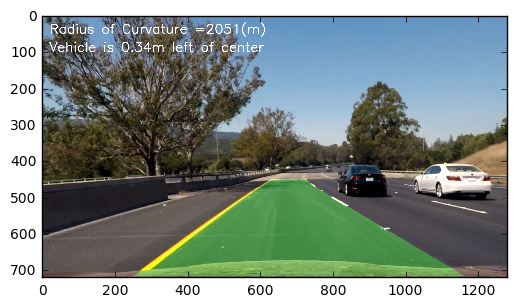

In [152]:
img_path=os.getcwd()+'/test_images/'
img=mpimg.imread(img_path+'test6.jpg')
ret_img=process_image(img, dbg=False)
plt.imshow(ret_img)
plt.show()

In [154]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_output = 'project_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip_output = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip_output.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_output))

[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


 45%|█████████████████▋                     | 573/1261 [05:34<07:33,  1.52it/s]

ValueError: attempt to get argmax of an empty sequence